<a href="https://colab.research.google.com/github/shilpasy/Stock-Pair-Similarity-Analysis-Inspired-by-Gene-Co-Expression-Networks/blob/main/Stock_Pair_Similarity_Analysis_Inspired_by_Gene_Co_Expression_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install what we need
!pip install yfinance --quiet

# imports
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from bs4 import BeautifulSoup
import requests
from IPython.display import display

In [ ]:
# ok setting params
NUM_STOCKS = 50
TOP_PAIRS = 10
START_DATE = '2022-05-01'
END_DATE = '2025-05-01'
ROLLING_WINDOW = 30

# grab nasdaq-100 tickers from slickcharts (way more stable than wiki, wiki source was failing multiple times)
url = 'https://www.slickcharts.com/nasdaq100'

import requests
from bs4 import BeautifulSoup

headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')
##tables = pd.read_html(str(soup))
tables = pd.read_html(StringIO(str(soup)))

tickers_df = tables[0]
tickers = tickers_df['Symbol'].tolist()[:NUM_STOCKS]

# download stock prices
data = yf.download(tickers, start=START_DATE, end=END_DATE)['Close'].dropna(axis=1)

# daily returns, Pct Change calculates the daily percentage return of each stock, NORMALIZATION (This way, correlation measures reflect true co-movement rather than differences in absolute price values)
returns = data.pct_change().dropna()

# calc correlations
corr_matrix = returns.corr()
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1].drop_duplicates()

[*********************100%***********************]  50 of 50 completed


In [ ]:
# top correlated pairs
top_corr_pairs = corr_pairs.head(TOP_PAIRS)
top_corr_pairs.index.names = ['Stock A', 'Stock B']
top_corr_pairs = top_corr_pairs.rename("Correlation").reset_index()

top_corr_pairs['Deviation'] = top_corr_pairs.apply(
    lambda row: calc_deviation(row['Stock A'], row['Stock B']), axis=1)

# deviation + z-score deviation
#  (drop z-score std later due to an error with GOOG)
def calc_deviation(stock_a, stock_b, window=ROLLING_WINDOW):
    diff = returns[stock_a] - returns[stock_b]
    roll_std = diff.rolling(window).std()
    return roll_std.mean()

# compute both metrics
top_corr_pairs[['StdDeviation', 'ZScoreDeviation']] = top_corr_pairs.apply(
    lambda row: pd.Series(calc_deviation_metrics(row['Stock A'], row['Stock B'])), axis=1)

# final sort
final_pairs = top_corr_pairs.sort_values('ZScoreDeviation').reset_index(drop=True)

# show as a table
display(final_pairs)

,Stock A,Stock B,Correlation,Deviation,StdDeviation,ZScoreDeviation
0,GOOG,GOOGL,0.997957,0.001265,0.001265,1.0
1,LRCX,KLAC,0.921610,0.010904,0.010904,1.0
2,QCOM,AMAT,0.752211,0.017916,0.017916,1.0
3,ADI,TXN,0.860102,0.010519,0.010519,1.0
4,KLAC,AMAT,0.919727,0.010500,0.010500,1.0
5,AMAT,LRCX,0.929352,0.010102,0.010102,1.0
6,CDNS,SNPS,0.895106,0.009761,0.009761,1.0
7,LRCX,QCOM,0.753091,0.018756,0.018756,1.0
8,KLAC,QCOM,0.750939,0.017665,0.017665,1.0
9,KLAC,ADI,0.748719,0.017299,0.017299,1.0


I notice that GOOG and GOOGL is the same company (coorelation is also quite high here), so I removed one (GOOGL) and kept one (GOOG) because they both represent Alphabet Inc. and behave nearly identically, so keeping both would artificially inflate correlation results by ranking the same company as its own top match.

# **Corrected code**

In [ ]:
# params
NUM_STOCKS = 50
TOP_PAIRS = 10
START_DATE = '2022-05-14'
END_DATE = '2025-05-14'
ROLLING_WINDOW = 30

# grab nasdaq-100 tickers from slickcharts (with headers to avoid 403)
headers = {'User-Agent': 'Mozilla/5.0'}
res = requests.get("https://www.slickcharts.com/nasdaq100", headers=headers)
soup = BeautifulSoup(res.text, 'html.parser')
tables = pd.read_html(StringIO(str(soup)))

# fetch the list
tickers_df = tables[0]
tickers = tickers_df['Symbol'].tolist()

# if both GOOG and GOOGL are in the list, keep only GOOG #####
if 'GOOG' in tickers and 'GOOGL' in tickers:
    tickers.remove('GOOGL')

# now slice the top N
tickers = tickers[:NUM_STOCKS]

# download price data
data = yf.download(filtered_tickers, start=START_DATE, end=END_DATE)['Close'].dropna(axis=1)

# compute returns
returns = data.pct_change().dropna()

# correlation matrix
corr_matrix = returns.corr()
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1].drop_duplicates()

# convert to dataframe safely
top_corr_pairs = corr_pairs.head(TOP_PAIRS)
top_corr_pairs.index.names = ['Stock A', 'Stock B']
top_corr_pairs = top_corr_pairs.rename("Correlation").reset_index()

# deviation function (no z-score — not meaningful)
def calc_deviation(stock_a, stock_b, window=ROLLING_WINDOW):
    diff = returns[stock_a] - returns[stock_b]
    return diff.rolling(window).std().mean()

# apply it
top_corr_pairs['Deviation'] = top_corr_pairs.apply(
    lambda row: calc_deviation(row['Stock A'], row['Stock B']), axis=1)

# sort by tightest (lowest) deviation
final_pairs = top_corr_pairs.sort_values('Deviation').reset_index(drop=True)

display(final_pairs)

[*********************100%***********************]  49 of 49 completed


,Stock A,Stock B,Correlation,Deviation
0,CDNS,SNPS,0.891925,0.009755
1,LRCX,AMAT,0.929074,0.010111
2,AMAT,KLAC,0.919558,0.010481
3,TXN,ADI,0.861045,0.010582
4,LRCX,KLAC,0.920438,0.010919
5,KLAC,ADI,0.747623,0.017260
6,QCOM,KLAC,0.747769,0.017658
7,QCOM,AMAT,0.745766,0.017900
8,LRCX,QCOM,0.745102,0.018833
9,ADI,LRCX,0.740563,0.018990


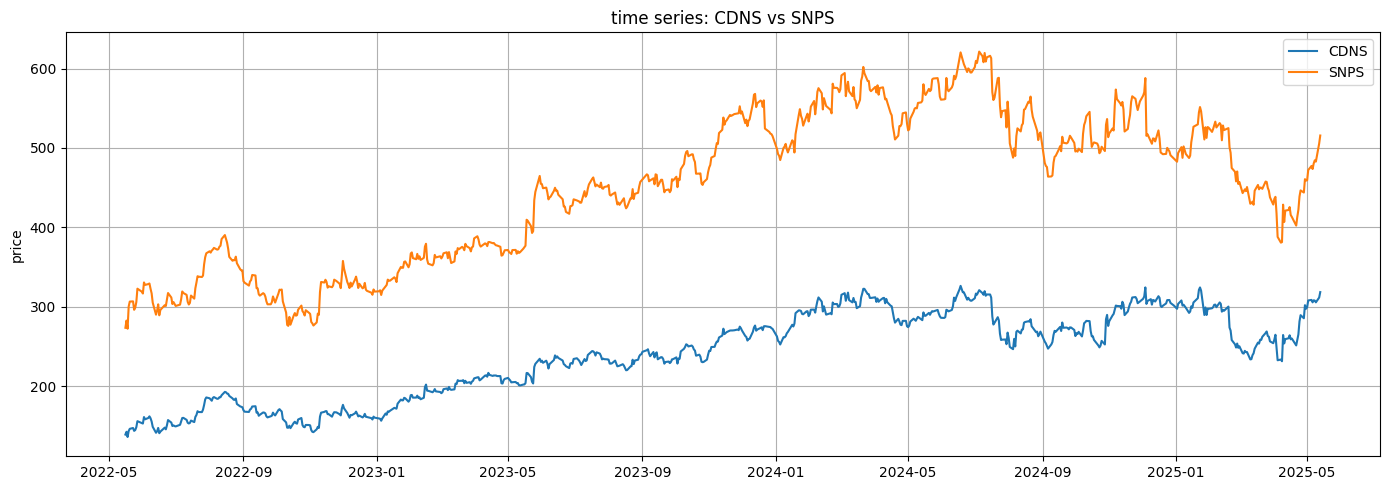

In [ ]:
# time series plot of top pair
stock1 = final_pairs.loc[0, 'Stock A']
stock2 = final_pairs.loc[0, 'Stock B']
pair_prices = data[[stock1, stock2]].dropna()

plt.figure(figsize=(14, 5))
plt.plot(pair_prices.index, pair_prices[stock1], label=stock1)
plt.plot(pair_prices.index, pair_prices[stock2], label=stock2)
plt.title(f'time series: {stock1} vs {stock2}')
plt.ylabel('price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

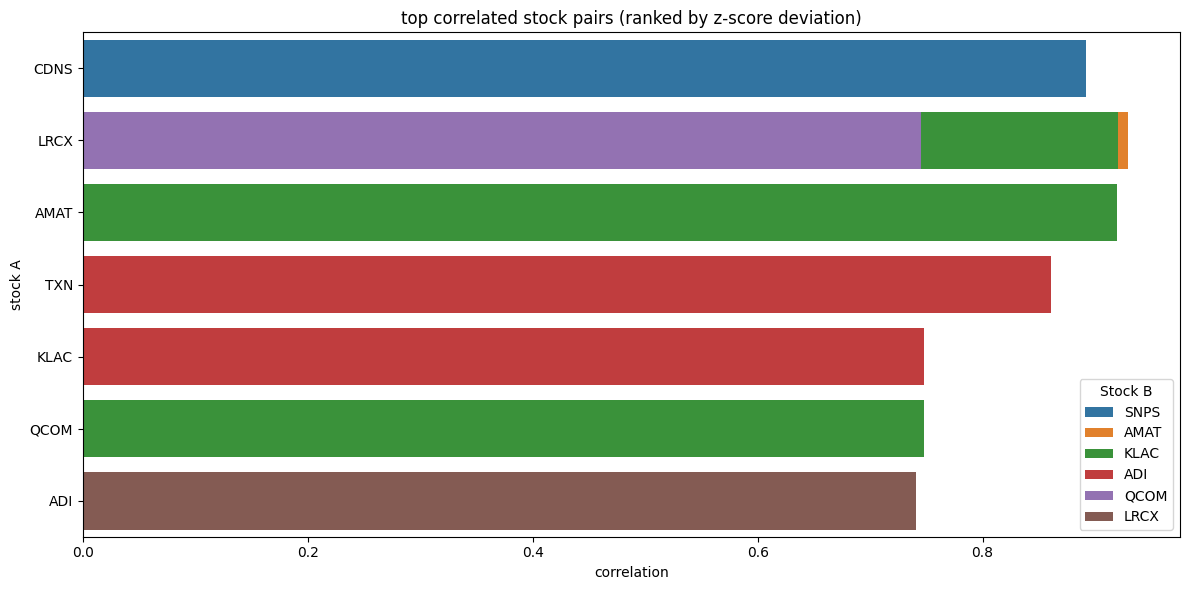

In [ ]:
# barplot showing how tightly they're correlated
plt.figure(figsize=(12, 6))
sns.barplot(data=final_pairs, x='Correlation', y='Stock A', hue='Stock B', dodge=False)
plt.title('top correlated stock pairs (ranked by z-score deviation)')
plt.xlabel('correlation')
plt.ylabel('stock A')
plt.tight_layout()
plt.show()

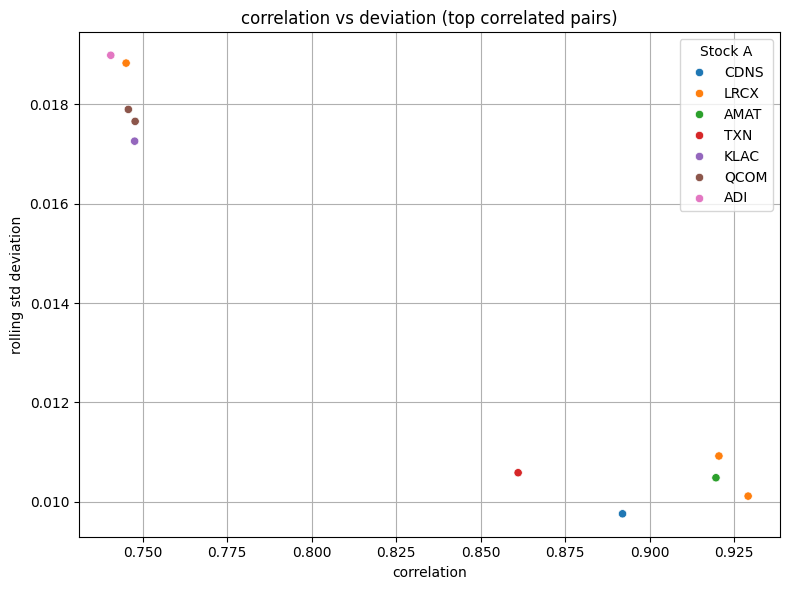

In [ ]:
# --- scatter plot: correlation vs deviation ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_pairs, x='Correlation', y='Deviation', hue='Stock A')
plt.title('correlation vs deviation (top correlated pairs)')
plt.xlabel('correlation')
plt.ylabel('rolling std deviation')
plt.grid(True)
plt.tight_layout()
plt.show()

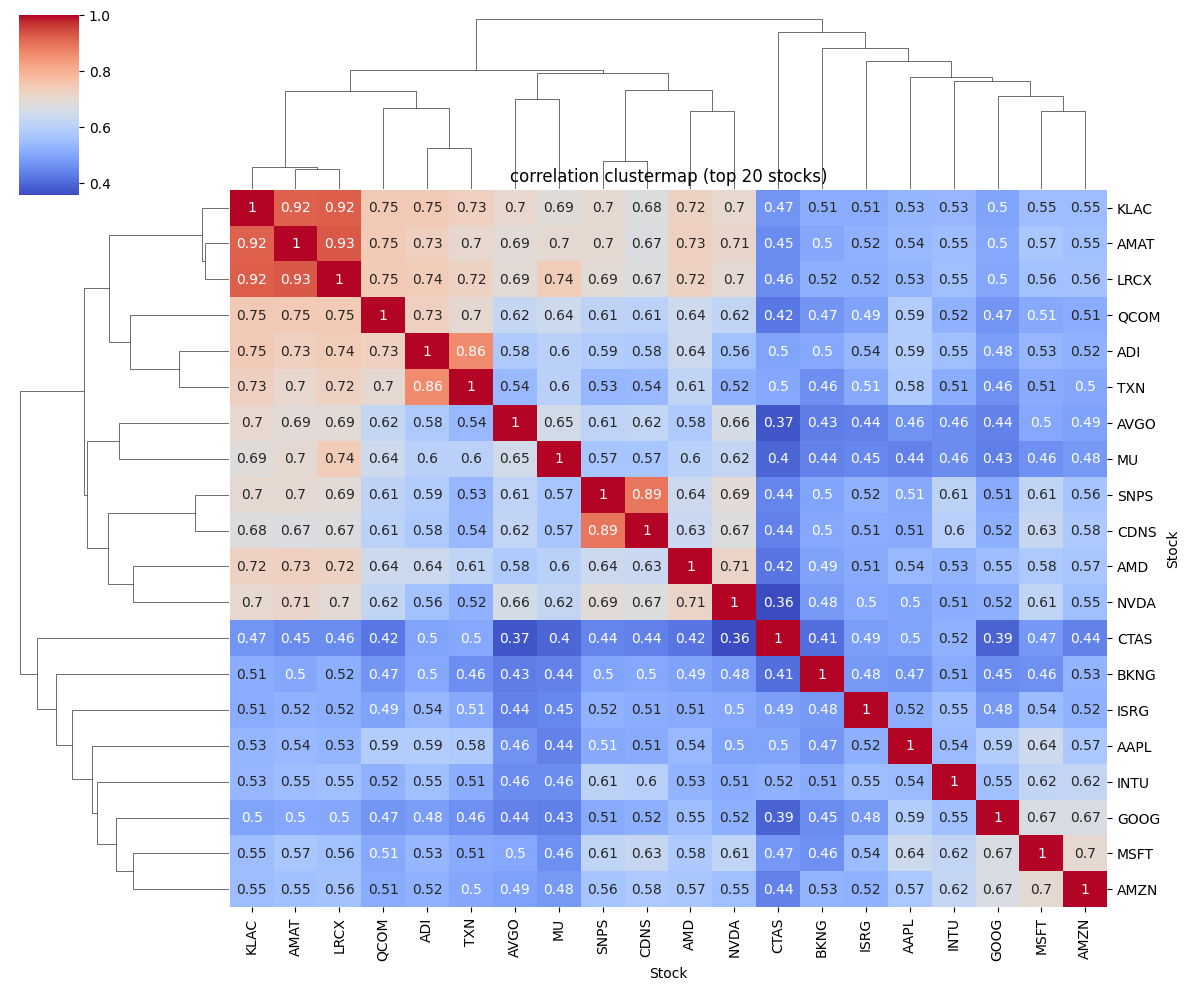

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# get top N most connected stocks
top_n_stocks = returns.corr().mean().sort_values(ascending=False).head(20).index.tolist()
sub_corr_matrix = returns[top_n_stocks].corr()

# create cluster heatmap
g = sns.clustermap(sub_corr_matrix, cmap="coolwarm", annot=True, figsize=(12, 10))
g.ax_heatmap.set_title("correlation clustermap (top 20 stocks)")

g.ax_heatmap.set_xlabel("Stock")
g.ax_heatmap.set_ylabel("Stock")

plt.show()

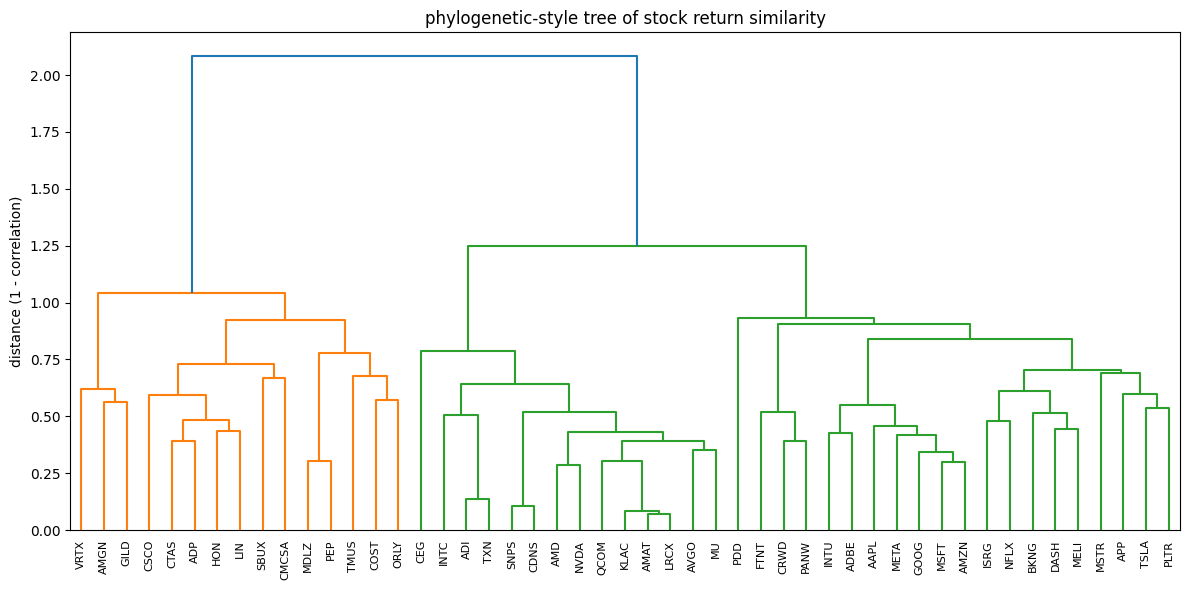

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# use correlation matrix for clustering
top_n_stocks = returns.corr().mean().sort_values(ascending=False).head(50).index.tolist()
sub_corr = returns[top_n_stocks].corr()

# convert correlation to distance
distance_matrix = 1 - sub_corr
condensed_dist = squareform(distance_matrix)

# hierarchical clustering
linkage_matrix = linkage(condensed_dist, method='ward')

# plot dendrogram (like a phylogenetic tree)
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=top_n_stocks, leaf_rotation=90)
plt.title('phylogenetic-style tree of stock return similarity')
plt.ylabel('distance (1 - correlation)')
plt.tight_layout()
plt.show()

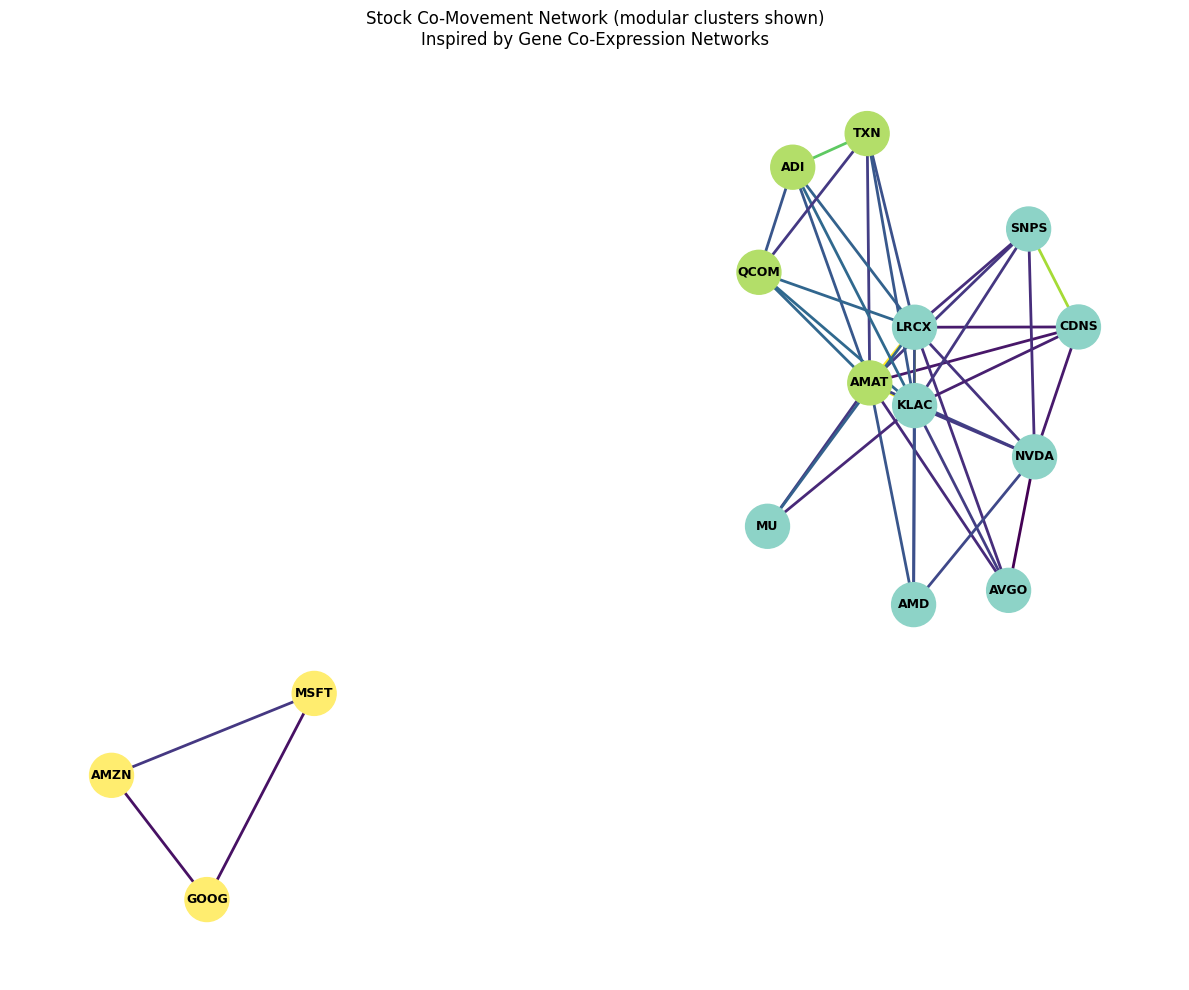

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community

# 1. get high-avg-correlation stocks
top_n_stocks = returns.corr().mean().sort_values(ascending=False).head(30).index.tolist()
sub_corr = returns[top_n_stocks].corr()

# 2. build graph with relaxed threshold
G = nx.Graph()
threshold = 0.65

for i in sub_corr.columns:
    for j in sub_corr.columns:
        if i != j and sub_corr.loc[i, j] >= threshold:
            G.add_edge(i, j, weight=sub_corr.loc[i, j])

# 3. skip if too few edges
if len(G.edges) < 3:
    print("still too sparse. try lowering the threshold more.")
else:
    # 4. community detection (like gene modules)
    communities = list(community.greedy_modularity_communities(G))
    node_colors = {}
    for i, comm in enumerate(communities):
        for node in comm:
            node_colors[node] = i
    color_list = [node_colors[n] for n in G.nodes()]

    # 5. draw final styled network
    pos = nx.spring_layout(G, seed=42, k=0.5)
    plt.figure(figsize=(12, 10))

    edges = G.edges(data=True)
    weights = [d['weight'] for (_, _, d) in edges]

    nx.draw_networkx_nodes(G, pos, node_color=color_list, cmap=plt.cm.Set3, node_size=1000)
    nx.draw_networkx_edges(G, pos, edge_color=weights, edge_cmap=plt.cm.viridis, width=2)
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

    plt.title("Stock Co-Movement Network (modular clusters shown)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

**Solution Overview**

**SUMMARY**

We wanted to find stock pairs that move together in the same way over time.

    First, we got the daily stock prices for the top 50 companies in the NASDAQ-100 list for the last 3 years.

    Then we calculated daily returns — this just means we looked at how much each stock went up or down each day (as a percentage).

    After that, we checked how similar each stock is to every other stock using something called correlation. A high correlation means they move together closely (e.g., if one goes up, the other usually does too).

    We picked the top 50 pairs with the highest correlation values.

    Then, we ranked these 50 pairs again by looking at how "tightly" they move together — using a rolling standard deviation, which tells us how much they drift apart over time. Lower values mean they stay close together more often.

This way, we found stock pairs that not only move in the same direction but also stick close to each other most of the time.

FUTURE DIRECTIONS:

    Track how many NAs were dropped, and explore alternatives like forward-filling, interpolation, imputation or restricting analysis to overlapping trading days — instead of just dropping rows.

    Try alternative deviation methods, such as:

        Price ratio tracking (used in cointegration),

        Residual standard deviation from linear regression, or

        Average absolute return difference — to see if rankings change across definitions.

    Analyze how stable correlations are over time by applying rolling window correlations — this can highlight pairs that consistently move together vs. those that drift.

    Compare different correlation metrics, like Spearman (for monotonic trends) or Kendal tau — to better capture rank-based or non-linear relationships between stocks.

    Cluster stocks by movement patterns using hierarchical clustering or PCA to group behaviorally similar stocks, and visualize sector-based correlation blocks.